In [221]:
import torch
from pycausal import *
from copy import deepcopy
import matplotlib.pyplot as plt
###444544
from numba import jit

In [222]:
class MDN(torch.nn.Module):
    def __init__(self, n_hidden, n_components, act = torch.nn.LeakyReLU() ):
        super(MDN,self).__init__()
        self.components = n_components
        
        nh = len(n_hidden)
        l = []
        for i in range(1,nh-1):
            l.append(
                nn.Linear(n_hidden[i-1],n_hidden[i]) 
            )
            l.append(
                act
            )
            #l.append(
            #    nn.BatchNorm1d(n_hidden[i])
            #)
        
        l = l + [nn.Linear(n_hidden[nh-2],n_hidden[nh-1]),act]
        #print(l)
        self.z_h = nn.Sequential( *l )
        
        self.z_pi = nn.Linear(n_hidden[-1], n_components)
        self.z_mu = nn.Linear(n_hidden[-1], n_components)
        self.z_sigma = nn.Linear(n_hidden[-1], n_components)
    
    #@jit(nopython=True, parallel=True)
    def forward(self, x):
        z_h = self.z_h(x)
        pi = F.softmax(self.z_pi(z_h), -1)
        mu = self.z_mu(z_h)
        
        sigma = torch.nn.ELU()(self.z_sigma(z_h)) + 1
        #sigma = torch.exp(self.z_sigma(z_h))
        return pi, mu, sigma
    
    #@jit(nopython=True, parallel=True)
    def loss(pi_mu_sigma, y, reduce=True, entropy_reg=True):
        pi, mu, sigma = pi_mu_sigma
        m = torch.distributions.Normal(loc=mu, scale=sigma)
        
        log_prob_y = m.log_prob(y) ## y | theta
        
        lp = torch.log(pi)
        
        log_prob_pi_y = log_prob_y + lp
        loss = -torch.logsumexp(log_prob_pi_y, dim=1) # log ( sum_i (exp xi) )
        
        if entropy_reg:
            entropy = -torch.sum(lp * pi,dim=1)/ pi.shape[1]
            loss = loss - 0.5 *entropy
        
        if reduce:
            return torch.mean(loss)
        else:
            return loss

In [223]:
## loading models
modelxy = torch.load("model_x->y")
modelyx = torch.load("model_y->x")

In [224]:
## loading SCM
base = SCM.load("base.scm")
transfer = SCM.load("transfer.scm")

In [225]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, n, scm, features ="X", labels="Y"):
        'Initialization'
        smps = scm._sample(n)
        self.X_train =smps[features]
        self.Y_train =smps[labels]

    def __len__(self):
        'Denotes the total number of samples'
        return self.X_train.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'

        return torch.tensor(self.X_train[index],dtype=torch.float32), torch.tensor(self.Y_train[index],dtype=torch.float32)

In [226]:
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader
import torch.nn.functional as F

#@jit(nopython=True, parallel=True)
def lrfind(model,scm,features="X",labels="Y",epoch=2000,batch=4,loss=MDN.loss):
    optim = torch.optim.Adam(model.parameters(), lr=1e-6)
    trainloader = DataLoader(
        Dataset(batch*epoch, scm, features=features, labels=labels), 
        batch_size=batch, 
        shuffle=False)

    lr_finder = LRFinder(model, optim, loss, device="cpu")
    lr_finder.range_test(trainloader, end_lr=10, num_iter=100, step_mode='exp')
    lr_finder.plot() # to inspect the loss-learning rate graph
    lr_finder.reset()

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


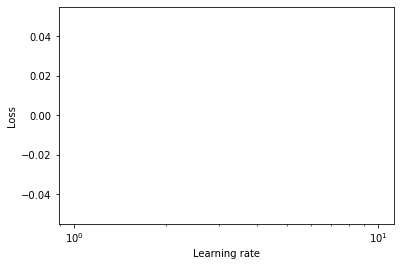

In [227]:
fmodel = deepcopy(modelxy)
lrfind(fmodel,transfer,features="X",labels="Y")

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


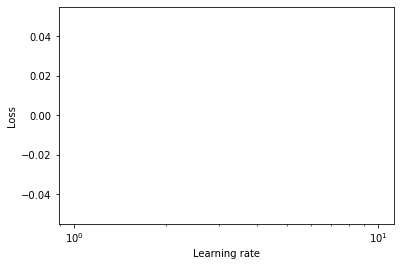

In [228]:
fmodel = deepcopy(modelyx)
lrfind(fmodel,transfer,features="Y",labels="X")

In [229]:
def fit(base, model, heads=1, lr=1e-4,features="X",labels="Y",traini=False):
    #model = MDN([1,200], 12)
    
    lossap=None
    #if traini :
    #    lossap = train(model,base,lr,features,labels, epoch= 2000)
    #    plt.plot(lossap)
    #    plt.show()
        
    smps= base._sample(300)
        
    xx = np.sort(smps[features].ravel()).reshape(-1,1)
    xx = torch.tensor(xx,dtype=torch.float32)

    pi, mu, sigma = model.forward(xx)

    #pi = F.softmax(pi,dim=1)
    #sigma = torch.exp(sigma)


    a = torch.sum(pi * mu, dim=1)

    plt.scatter(smps[features], smps[labels])
    plt.plot(xx.numpy().ravel(), a.detach().numpy(),c="black")
    for i in range(heads):
        plt.plot(xx.numpy().ravel(), mu[:,i].detach().numpy())

    plt.show()
    
    return model

In [213]:
class ProposalSCM():
    def __init__(self, model, lr):
        self.omodel = model
        self.model = deepcopy(model)
        self.optim = torch.optim.Adam(
            self.model.parameters(), lr=lr)
        self.accumulation = torch.zeros((1,1)) 
        self.lr = lr
    
    def copy(self):
        self.model = deepcopy(self.omodel)
        self.accumulation = torch.zeros((1,1))
        self.optim = torch.optim.Adam(
            self.model.parameters(), lr=self.lr)
        
    def step(self,X_train,Y_train):
        y_h = self.model.forward(X_train)
        energy = MDN.loss(y_h, Y_train,entropy_reg=True)
        self.optim.zero_grad()
        energy.backward()
        self.optim.step()
        
    def evaluate(self,X_train,Y_train):
        yt_h = self.model.forward(X_train)
        energy = MDN.loss(yt_h, Y_train,entropy_reg=False)
        
        r = energy.detach()
        self.accumulation += r
        
        return r
    
    def online_likelihood(self):
        return self.accumulation        

In [214]:
def meta(transfer, 
         features, 
         labels, 
         modelxy, 
         modelyx, 
         steps=15,
         episodes=300,
         lr = 1e-3,
         metalr = 1e-2,
         val=300):
    
    tpaths = {}
    
    scmxy = ProposalSCM(modelxy,lr)
    scmyx = ProposalSCM(modelyx,lr)
    
    ## setup meta model. 
    gamma = torch.nn.parameter.Parameter(torch.zeros((1,1)))
    
    optimizer = torch.optim.SGD(
              [ gamma ], lr=metalr)
    
    gpath = []
    
    for e in range(episodes):
        ## setup new model
        scmxy.copy()
        scmyx.copy()
     
        tpaths[e] = []
        
        ## prepare dataset
        dt = transfer._sample(steps+val)
        
        Xt_train = torch.tensor(dt[features][steps:], dtype=torch.float32)
        Yt_train = torch.tensor(dt[labels][steps:], dtype=torch.float32)
    
        for i in range(steps):

            smps = transfer._sample(1)
            X_train = torch.tensor(dt[features][i].reshape(-1,1), dtype=torch.float32)
            Y_train = torch.tensor(dt[labels][i].reshape(-1,1), dtype=torch.float32)
            
            scmxy.step(X_train, Y_train)
            scmyx.step(Y_train, X_train)

            # eval
            
            energyxy = scmxy.evaluate(X_train, Y_train)
            energyyx = scmyx.evaluate(Y_train, X_train)
            
            energy = energyyx - energyxy
            tpaths[e].append(energy.numpy())
        
        
        pb = torch.nn.Sigmoid()(gamma)
        
        regret = pb * scmxy.online_likelihood() + (1 - pb) * scmyx.online_likelihood()
        
        optimizer.zero_grad()
        regret.backward()
        optimizer.step()
        
        tpaths[e] = np.stack(tpaths[e])
        #lt.plot( tpaths[e], color="red")
        
        gpath.append(pb.detach().numpy().ravel())
    #print(gamma)   
    return tpaths, gpath

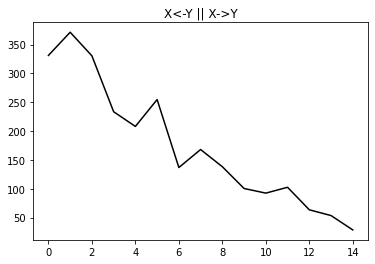

In [219]:
l1 , g = meta(transfer,"X","Y",modelxy,modelyx,
              lr=1e-3, metalr=1e-2,episodes=200, 
              steps=15)

l1 = list( l1.values() ) 


plt.title("X<-Y || X->Y")
plt.plot( sum(l1) / len(l1), label="x->y", color="black")
plt.show()
#l2 = list( metar(transfer,"Y","X",modelyx,lr=1e-3).values() ) 
#plt.title("Y->X")
#plt.show()

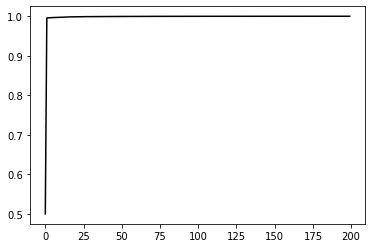

In [220]:
#plt.plot( sum(l1) / len(l1), label="x->y")
#plt.plot( sum(l2) / len(l2), label="y->x")
plt.plot(g, color="black")

#plt.legend()
plt.show()